In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
from __future__ import print_function
import numpy as np 
import os
import glob
import numpy as np 
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from PIL import Image
from sklearn.metrics import roc_curve, auc # roc curve tools
from sklearn.metrics import jaccard_score


In [ ]:
import pickle
with open('/content/drive/MyDrive/flood_mapping/NEW/UNET/100 EPOCHS/BATCH 2/HistoryDict', 'rb') as f:
    x = pickle.load(f)


#print( 'Training Accuracy : ', round(x['accuracy'][-1],4))

#print( 'Validation Accuracy : ', round(x['val_accuracy'][-1],4)) 

#print( 'Training Loss : ', round(x['loss'][-1],4))

#print( 'Validation Loss : ', round(x['val_loss'][-1],4))

In [ ]:



fig, ax = plt.subplots(figsize=(15,12),dpi=80)
ax.plot(np.array(FloodNet.history['loss']),'b-',marker=".",markersize=10, markeredgecolor='k',label='Training Set',linewidth=4)
ax.plot(np.array(FloodNet.history['val_loss']),'r-',linestyle='-',marker=".",markersize=10,markeredgecolor='k',label='Validation Set',linewidth=4)
ax.set_title('Model Loss',fontsize=24)
ax.set_ylabel('Loss ',fontsize=50)
ax.set_xlabel('Epochs',fontsize=50)
ax.legend(loc='upper right',fontsize=20)
ax.set_ylim(ymin=0,ymax=3)
for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.show()


fig, ax = plt.subplots(figsize=(15,12),dpi=80)
ax.plot(np.array(FloodNet.history['accuracy']),'b-',marker=".",markersize=10, markeredgecolor='k',label='Training Set',linewidth=4)
ax.plot(np.array(FloodNet.history['val_accuracy']),'r-',linestyle='-',marker=".",markersize=10,markeredgecolor='k',label='Validation Set',linewidth=4)
ax.set_title('Model Accuracy',fontsize=24)
ax.set_ylabel('Accuracy ',fontsize=50)
ax.set_xlabel('Epoch',fontsize=50)
ax.legend(loc='lower right',fontsize=20)
ax.set_ylim(ymin=0,ymax=1)
for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.show()




In [3]:
def load_images_from_folder(folder):
    images = []
    img_list = os.listdir(folder)
    img_list.sort()
    for filename in img_list:
        img = io.imread(os.path.join(folder,filename))
        img = img / 255
        images.append(img)
    return images

y_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/test/MASK')
x1_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/test/BEFORE') 
x2_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/test/AFTER')
x3_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS1/test/BEFORE') 
x4_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS1/test/AFTER')





In [4]:
############## UNET SENTINEL 2 BATCH 8
S2acc = [0.94565, 0.93535, 0.93893, 0.27502, 0.92014, 0.84866, 0.96802, 0.92303, 0.72002, 0.87933, 0.83572, 0.92784, 0.67963, 0.78665, 0.87498, 0.39444, 0.64145, 0.58971, 0.86536, 0.88937, 0.83669, 0.95361, 0.92386, 0.86574, 0.97519, 0.90169, 0.90187, 0.92229, 0.94974, 0.94537, 0.9641, 0.86932, 0.92685, 0.90631, 0.80571, 0.83411, 0.85703, 0.92896, 0.48584, 0.7287, 0.83298, 0.91568, 0.87903, 0.87854, 0.76733, 0.87518, 0.87491, 0.88519, 0.8772, 0.77441, 0.9799, 0.85463, 0.88158, 0.96176, 0.87523, 0.86089, 0.84026, 0.70724, 0.66501, 0.70663, 0.70015, 0.79108, 0.83578, 0.95139, 0.94479, 0.95526, 0.83751, 0.9229, 0.8643, 0.86334]
S2iou = [0.52109, 0.67604, 0.61176, 0.13836, 0.46007, 0.4677, 0.7598, 0.46755, 0.42182, 0.78095, 0.55924, 0.72133, 0.38492, 0.41298, 0.52963, 0.23061, 0.32095, 0.38279, 0.43654, 0.44469, 0.70854, 0.47681, 0.64699, 0.55327, 0.82096, 0.54041, 0.8027, 0.81973, 0.72756, 0.4731, 0.81275, 0.70922, 0.48816, 0.50134, 0.61897, 0.56799, 0.6286, 0.46448, 0.28323, 0.57123, 0.7012, 0.8064, 0.57076, 0.62077, 0.54411, 0.67831, 0.55605, 0.64121, 0.6677, 0.53849, 0.70584, 0.58102, 0.77791, 0.65171, 0.76246, 0.5282, 0.72444, 0.54578, 0.49333, 0.54286, 0.42266, 0.46335, 0.6998, 0.6967, 0.72586, 0.80681, 0.55792, 0.4709, 0.54076, 0.56681]
S2fwiou = [0.89556, 0.89301, 0.90239, 0.0793, 0.8469, 0.72464, 0.93715, 0.852, 0.53384, 0.78688, 0.70577, 0.87526, 0.59003, 0.62386, 0.7687, 0.21979, 0.41148, 0.37376, 0.74886, 0.79099, 0.71724, 0.90938, 0.86294, 0.75063, 0.95656, 0.83854, 0.82186, 0.85525, 0.90809, 0.89402, 0.93347, 0.76136, 0.87262, 0.82192, 0.65934, 0.76849, 0.74116, 0.86296, 0.32473, 0.57188, 0.72105, 0.84117, 0.83865, 0.79303, 0.67779, 0.80531, 0.81372, 0.83524, 0.8068, 0.63278, 0.96459, 0.75918, 0.79064, 0.92672, 0.78135, 0.75121, 0.7244, 0.54902, 0.48474, 0.53814, 0.49707, 0.65413, 0.72701, 0.92039, 0.89993, 0.91428, 0.78015, 0.85336, 0.76382, 0.78603]
#Average Pixel Accuracy : 0.8412
#Mean IoU : 0.5791
#FW IoU : 0.7461
#training time: 17.003


indexesS2 = np.argsort(S2iou)
S2_y_pred = load_images_from_folder('/content/drive/MyDrive/flood_mapping/NEW/UNET/50 EPOCHS/BATCH 8/PREDICTIONS')
indexesS2 = np.argsort(S2iou)


In [5]:
############## UNET SENTINEL 1 BATCH 8
S1acc = [0.88728, 0.92203, 0.93616, 0.41716, 0.94171, 0.84383, 0.97032, 0.95337, 0.67984, 0.85577, 0.88828, 0.91068, 0.93398, 0.88127, 0.94464, 0.63129, 0.92912, 0.87141, 0.96855, 0.9165, 0.77237, 0.96999, 0.73383, 0.64188, 0.91049, 0.68881, 0.89856, 0.50224, 0.95377, 0.97574, 0.95694, 0.90466, 0.9834, 0.91936, 0.80875, 0.76036, 0.86006, 0.77336, 0.55481, 0.58527, 0.64679, 0.86052, 0.59982, 0.60292, 0.60364, 0.645, 0.61284, 0.38278, 0.48169, 0.33746, 0.36803, 0.62746, 0.80888, 0.96375, 0.85506, 0.84486, 0.51518, 0.57944, 0.46577, 0.56424, 0.83334, 0.82436, 0.75275, 0.95819, 0.91473, 0.92133, 0.91571, 0.86754, 0.80031, 0.87549]
S1iou = [0.55229, 0.48752, 0.46891, 0.25962, 0.60831, 0.45736, 0.77672, 0.72075, 0.50001, 0.73316, 0.74113, 0.70216, 0.72972, 0.67329, 0.80645, 0.43771, 0.85821, 0.77156, 0.87124, 0.73196, 0.62349, 0.71441, 0.43356, 0.3684, 0.58864, 0.39436, 0.79477, 0.33447, 0.78042, 0.80713, 0.77486, 0.80358, 0.86114, 0.59445, 0.6255, 0.5019, 0.66473, 0.45796, 0.37234, 0.40704, 0.47796, 0.68399, 0.35045, 0.40332, 0.40129, 0.43692, 0.3566, 0.22342, 0.30537, 0.20215, 0.19589, 0.41714, 0.67734, 0.68165, 0.70846, 0.4732, 0.27222, 0.30278, 0.26301, 0.36216, 0.69127, 0.53089, 0.49415, 0.66391, 0.52235, 0.66146, 0.57668, 0.47575, 0.4335, 0.51537]
S1fwiou = [0.8447, 0.85529, 0.88592, 0.23599, 0.88753, 0.71826, 0.94156, 0.91527, 0.53398, 0.74623, 0.80897, 0.85555, 0.87412, 0.783, 0.89811, 0.44927, 0.86853, 0.77226, 0.9393, 0.86804, 0.63069, 0.94556, 0.66084, 0.53372, 0.87131, 0.62819, 0.81556, 0.32394, 0.92007, 0.95643, 0.9204, 0.82981, 0.96763, 0.85027, 0.66469, 0.6891, 0.75675, 0.7203, 0.39386, 0.40844, 0.4784, 0.74474, 0.54961, 0.49336, 0.49763, 0.54211, 0.54894, 0.30754, 0.37043, 0.21385, 0.34176, 0.52057, 0.68367, 0.93169, 0.7412, 0.72422, 0.27013, 0.3388, 0.23292, 0.34561, 0.71552, 0.69932, 0.58099, 0.92345, 0.8383, 0.85188, 0.85585, 0.80594, 0.68862, 0.78633]
#Average Pixel Accuracy : 0.7781
#Mean IoU : 0.5507
#FW IoU : 0.6828
#training time: 18.055


indexesS1 = np.argsort(S1iou)
S1_y_pred = load_images_from_folder('/content/drive/MyDrive/flood_mapping/NEW/UNET/SENTINEL 1/50 EPOCHS/BATCH 8/PREDICTIONS')



In [6]:
############ BITEMPORAL BATCH 8 


acc_bi = [0.9635, 0.85289, 0.86707, 0.29178, 0.9209, 0.84392, 0.96831, 0.92209, 0.73343, 0.85722, 0.74776, 0.89659, 0.78137, 0.79863, 0.91602, 0.59691, 0.65034, 0.71426, 0.8728, 0.88937, 0.84698, 0.95425, 0.8381, 0.94246, 0.95757, 0.8875, 0.78214, 0.90068, 0.92311, 0.94452, 0.93408, 0.89908, 0.94225, 0.92918, 0.84088, 0.69388, 0.85876, 0.92876, 0.80873, 0.92473, 0.88387, 0.93518, 0.90414, 0.88516, 0.87238, 0.91342, 0.9505, 0.89928, 0.88368, 0.96011, 0.97945, 0.89035, 0.91045, 0.93689, 0.77785, 0.79022, 0.84171, 0.687, 0.8812, 0.75432, 0.74767, 0.78293, 0.87656, 0.97162, 0.964, 0.96027, 0.88977, 0.93282, 0.90379, 0.86598]
iou_bi = [0.72629, 0.58235, 0.56361, 0.14961, 0.46359, 0.43862, 0.76202, 0.46104, 0.46448, 0.74919, 0.49098, 0.69139, 0.56015, 0.44755, 0.72241, 0.40926, 0.3364, 0.55009, 0.49074, 0.44469, 0.73342, 0.48819, 0.58799, 0.81896, 0.76171, 0.619, 0.63873, 0.76642, 0.70277, 0.48715, 0.74521, 0.79319, 0.53088, 0.65652, 0.71229, 0.45402, 0.70083, 0.46618, 0.63838, 0.85936, 0.77915, 0.86053, 0.60839, 0.65501, 0.65819, 0.71986, 0.7779, 0.65399, 0.68076, 0.90584, 0.65914, 0.6604, 0.81828, 0.69097, 0.63256, 0.53163, 0.72378, 0.52312, 0.78354, 0.6055, 0.52485, 0.45325, 0.76723, 0.78275, 0.8333, 0.85102, 0.53485, 0.56921, 0.68157, 0.63827]
fwiou_bi = [0.9345, 0.80212, 0.82841, 0.09075, 0.84807, 0.71302, 0.93772, 0.85025, 0.56177, 0.75238, 0.61982, 0.83995, 0.6972, 0.64409, 0.85153, 0.39944, 0.42418, 0.54707, 0.76761, 0.79099, 0.73616, 0.91097, 0.77323, 0.89264, 0.93315, 0.83566, 0.64996, 0.81539, 0.87904, 0.8947, 0.89368, 0.82077, 0.89123, 0.87024, 0.72934, 0.61716, 0.76678, 0.86301, 0.66896, 0.85957, 0.79634, 0.88067, 0.86622, 0.8069, 0.79867, 0.85026, 0.91629, 0.85077, 0.81547, 0.92425, 0.96168, 0.80912, 0.8332, 0.90661, 0.64428, 0.69404, 0.72403, 0.5222, 0.78871, 0.60599, 0.5781, 0.64533, 0.78755, 0.94883, 0.93609, 0.92854, 0.8268, 0.87594, 0.83117, 0.79984]
#Average Pixel Accuracy : 0.8608
#Mean IoU : 0.6319
#FW IoU : 0.7765
#training time: 24.88


bi_y_pred = load_images_from_folder('/content/drive/MyDrive/flood_mapping/NEW/BITEMPORAL/50 EPOCHS /BATCH 8/PREDICTIONS')
indexesbi = np.argsort(iou_bi)


In [7]:
############ MULTIMODAL BATCH 8 

acc_mult = [0.9615, 0.86734, 0.87975, 0.89352, 0.96185, 0.89053, 0.96832, 0.93198, 0.73338, 0.87834, 0.90344, 0.91068, 0.93047, 0.95815, 0.94371, 0.81854, 0.70636, 0.8701, 0.9243, 0.94751, 0.80125, 0.94113, 0.85547, 0.94083, 0.94452, 0.89, 0.91953, 0.94061, 0.95021, 0.96974, 0.94553, 0.91766, 0.97406, 0.87939, 0.84033, 0.82947, 0.8858, 0.95348, 0.82715, 0.9091, 0.83363, 0.94917, 0.868, 0.86554, 0.7625, 0.87343, 0.94832, 0.88371, 0.78667, 0.92096, 0.97903, 0.89044, 0.93179, 0.93837, 0.83966, 0.83894, 0.84814, 0.69176, 0.91325, 0.88919, 0.869, 0.79187, 0.79483, 0.94379, 0.94279, 0.9659, 0.84166, 0.9319, 0.89209, 0.87546]
iou_mult = [0.71388, 0.59886, 0.57555, 0.78532, 0.74624, 0.60186, 0.76209, 0.5291, 0.56819, 0.7814, 0.75936, 0.71646, 0.76559, 0.88496, 0.80354, 0.68544, 0.43632, 0.76871, 0.68678, 0.79302, 0.66806, 0.67377, 0.60705, 0.8215, 0.72161, 0.62347, 0.84032, 0.86446, 0.77342, 0.74353, 0.785, 0.81631, 0.79748, 0.63081, 0.71725, 0.57662, 0.75269, 0.74668, 0.66453, 0.83187, 0.70711, 0.88508, 0.56719, 0.66177, 0.5446, 0.68086, 0.77397, 0.63486, 0.57043, 0.83033, 0.69776, 0.66421, 0.86039, 0.69498, 0.71372, 0.56642, 0.73574, 0.52793, 0.83801, 0.79838, 0.74386, 0.60393, 0.65274, 0.70595, 0.77778, 0.87014, 0.58052, 0.55747, 0.6538, 0.63091]
fwiou_mult = [0.93126, 0.81804, 0.84185, 0.81559, 0.92608, 0.79371, 0.93774, 0.86863, 0.59503, 0.78538, 0.82843, 0.8579, 0.87914, 0.9208, 0.89653, 0.69028, 0.50658, 0.7698, 0.85612, 0.90904, 0.66636, 0.91406, 0.79268, 0.89185, 0.91635, 0.83861, 0.85341, 0.88929, 0.91556, 0.94424, 0.91088, 0.84645, 0.95132, 0.81998, 0.72991, 0.76444, 0.80696, 0.92176, 0.69406, 0.83222, 0.72241, 0.90359, 0.82734, 0.79009, 0.67226, 0.80393, 0.91357, 0.83313, 0.70144, 0.85881, 0.96332, 0.81017, 0.87123, 0.90844, 0.73021, 0.74352, 0.73562, 0.52529, 0.8414, 0.80081, 0.76664, 0.68905, 0.67065, 0.91384, 0.9063, 0.93806, 0.78576, 0.87348, 0.81436, 0.80799]
#Average Pixel Accuracy : 0.89
#Mean IoU : 0.705
#FW IoU : 0.8207
#training time: 34.73



mult_y_pred = load_images_from_folder('/content/drive/MyDrive/flood_mapping/NEW/MULTIMODAL/50 EPOCHS/BATCH 8/PREDICTIONS')
indexesmult = np.argsort(iou_mult)

In [8]:
######################################  SUPPORT VECTOR MACHINES ###################################################


svm_acc =[0.95798, 0.82147, 0.79236, 0.43477, 0.91753, 0.84192, 0.97946, 0.92368, 0.74168, 0.85997, 0.79607, 0.92462, 0.78725, 0.80092, 0.91652, 0.51492, 0.69305, 0.65546, 0.88512, 0.89029, 0.80397, 0.93593, 0.88495, 0.92487, 0.78458, 0.92668, 0.88217, 0.91953, 0.93086, 0.94997, 0.95685, 0.886, 0.93394, 0.81662, 0.78242, 0.64699, 0.74901, 0.92894, 0.80888, 0.88257, 0.84425, 0.9384, 0.87225, 0.83292, 0.84877, 0.8998, 0.94533, 0.87598, 0.78908, 0.90691, 0.97755, 0.89453, 0.91621, 0.9623, 0.84042, 0.76799, 0.81717, 0.63583, 0.87292, 0.85773, 0.80426, 0.79599, 0.78377, 0.91972, 0.91907, 0.96786, 0.81052, 0.93279, 0.90608, 0.80508]
svm_iou = [0.75031, 0.54894, 0.49175, 0.27336, 0.49415, 0.44418, 0.84686, 0.47215, 0.51376, 0.75169, 0.52751, 0.73932, 0.55046, 0.44863, 0.71431, 0.30471, 0.41169, 0.46839, 0.58804, 0.45065, 0.67196, 0.58483, 0.65578, 0.79807, 0.48871, 0.66313, 0.76207, 0.82012, 0.687, 0.58519, 0.80429, 0.7733, 0.53174, 0.55434, 0.63813, 0.41429, 0.5745, 0.5186, 0.63473, 0.78716, 0.71753, 0.86225, 0.54576, 0.61032, 0.63662, 0.71171, 0.76204, 0.61712, 0.57138, 0.80504, 0.68431, 0.65165, 0.83026, 0.77077, 0.71516, 0.51948, 0.69082, 0.46374, 0.77112, 0.7469, 0.62323, 0.42911, 0.63761, 0.64425, 0.72618, 0.87597, 0.5454, 0.56009, 0.68681, 0.56143]
svm_fwiou = [0.93165, 0.76787, 0.74971, 0.24854, 0.84969, 0.71319, 0.95956, 0.85321, 0.5891, 0.75703, 0.66682, 0.87547, 0.70335, 0.64592, 0.85, 0.28753, 0.48632, 0.46223, 0.80022, 0.79291, 0.67057, 0.90219, 0.82794, 0.87026, 0.73978, 0.87876, 0.78749, 0.85298, 0.88427, 0.90966, 0.92508, 0.80128, 0.88388, 0.7495, 0.64929, 0.56798, 0.62837, 0.8701, 0.66689, 0.78769, 0.73712, 0.88439, 0.83042, 0.74953, 0.77186, 0.83572, 0.90889, 0.82362, 0.70419, 0.83651, 0.96117, 0.81032, 0.84373, 0.93923, 0.73136, 0.67155, 0.69085, 0.459, 0.77596, 0.75065, 0.66245, 0.64597, 0.65595, 0.88452, 0.87502, 0.94123, 0.75155, 0.87463, 0.83444, 0.72983]
#Average Pixel Accuracy : 0.8487
#Mean IoU : 0.6245
#FW IoU : 0.7631
indexessvm = np.argsort(svm_iou)
svm_y_pred = load_images_from_folder('/content/drive/MyDrive/flood_mapping/NEW/SVM/MULTIMODAL/PREDICTIONS')

print(indexessvm)

[ 3 15 16 35 61  5 13 19 57 17  7 24  2  4  8 37 55 10 32 66 42  1 12 33
 67 69 48 36 21 29 18 43 47 60 38 44 62 34 63 51 22 25 20 50 68 28 56 45
 14 54 40 64 11 59  0  9 46 26 53 58 31 39 23 30 49 27 52  6 41 65]


In [9]:
#[66 45 50 62 44 63 47 48 56 49 58 37 51 33 42 52 38 27 57 54 43 46 25 39
#  8 53 40 64 23 55 24 67 35 41 69  2 34 22 68 59  1 21  6 15 20 36 18  0
# 61  9 11 60 31 19 16 17 12  7 30 29  5 28  4 26 14 65  3 10 32 13]


print(indexesS1)
print(indexesS2)
print(indexesbi)
print(indexesmult)



[50 49 47  3 58 56 57 48 27 42 46 59 23 38 25 44 43 39 51 68 22 45 15  5
 37  2 55 67 40  1 62  8 35 69 64 61  0 66 24 33  4 20 34 65 63 36 13 52
 53 41 60 11 54 21  7 12 19  9 10 17 30  6 28 26 31 14 29 16 32 18]
[ 3 15 38 16 17 12 13  8 60 18 19  4 61 37  7  5 67 29 21 32 58 33  0 55
 14 49 25 68 59 44 57 23 46 66 10 69 35 42 39 51  2 34 43 36 47 22 53 48
  1 45 63 62 40 50 20 31 11 56 64 28  6 54 52  9 26 41 65 30 27 24]
[ 3 16 15  5 19 13 61 35  7  4  8 37 29 21 18 10 57 60 32 55 66 17 12  2
 67  1 22 59 42 25 54 69 38 26 47 43 33 44 50 51 48 68 53 11 36 28 34 45
 14 56  0 20 30  9 24  6 27 62 46 40 63 58 31 52 23 64 65 39 41 49]
[16 57  7 44 67 55 42  8 48  2 35 66  1  5 61 22 25 33 69 47 62 68 43 51
 38 20 21 45 15 18 53 50 63 40 54  0 11 34 24 56 29 60  4 37 36 10  6 12
 17 28 46 64  9 30  3 19 32 59 14 31 23 49 39 58 26 52 27 65 13 41]


Pixel Accuracy S1 / S2 / Bi / Multi / SVM :  0.5022 /  0.9223  /  0.9007  /  0.9406  /  0.9195
IoU S1 / S2 / Bi / Multi / SVM :  0.3345 /  0.8197  /  0.7664  /  0.8645  /  0.8201
FW IoU S1 / S2 / Bi / Multi / SVM :  0.3239 /  0.8552  /  0.8154  /  0.8893  /  0.853


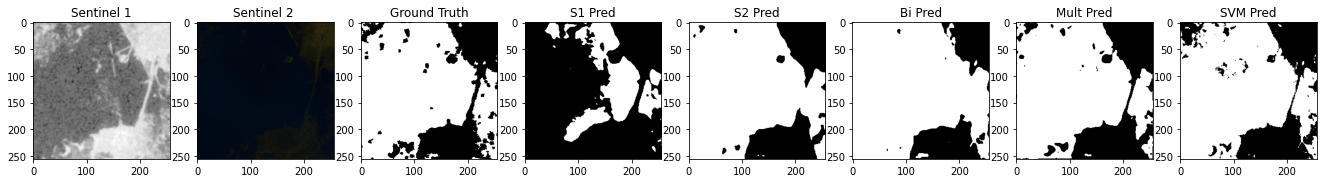

In [13]:
index = 27
fig = plt.figure(figsize=(23,23))
ax = fig.add_subplot(1, 8, 1)
imgplot = plt.imshow(x4_true[index],cmap=plt.cm.gray)
ax.set_title('Sentinel 1')
ax = fig.add_subplot(1, 8, 2)
imgplot = plt.imshow(x2_true[index],cmap=plt.cm.gray)
ax.set_title('Sentinel 2 ')
ax = fig.add_subplot(1, 8, 3)
imgplot = plt.imshow(y_true[index],cmap=plt.cm.gray)
ax.set_title('Ground Truth')
ax = fig.add_subplot(1, 8, 4)
imgplot = plt.imshow(S1_y_pred[index],cmap=plt.cm.gray)
ax.set_title('S1 Pred')
ax = fig.add_subplot(1, 8, 5)
imgplot = plt.imshow(S2_y_pred[index],cmap=plt.cm.gray)
ax.set_title('S2 Pred')
ax = fig.add_subplot(1, 8, 6)
imgplot = plt.imshow(bi_y_pred[index],cmap=plt.cm.gray)
ax.set_title('Bi Pred')
ax = fig.add_subplot(1, 8, 7)
imgplot = plt.imshow(mult_y_pred[index],cmap=plt.cm.gray)
ax.set_title('Mult Pred')
ax = fig.add_subplot(1, 8, 8)
imgplot = plt.imshow(svm_y_pred[index],cmap=plt.cm.gray)
ax.set_title('SVM Pred')


print("Pixel Accuracy S1 / S2 / Bi / Multi / SVM : ", str(round(S1acc[index], 4 )),"/ ", str(round(S2acc[index], 4 )), " / ",str(round(acc_bi[index], 4 )), " / ",str(round(acc_mult[index], 4 )), " / ",str(round(svm_acc[index], 4 ))  )

print("IoU S1 / S2 / Bi / Multi / SVM : ", str(round(S1iou[index], 4 )),"/ ", str(round(S2iou[index], 4 )), " / ",str(round(iou_bi[index], 4 )), " / ",str(round(iou_mult[index], 4 )), " / ",str(round(svm_iou[index], 4 ))   )

print("FW IoU S1 / S2 / Bi / Multi / SVM : ", str(round(S1fwiou[index], 4 )),"/ ", str(round(S2fwiou[index], 4 )), " / ",str(round(fwiou_bi[index], 4 )), " / ",str(round(fwiou_mult[index], 4 )), " / ",str(round(svm_fwiou[index], 4 ))   )

In [ ]:


jaccard_score(bi_y_pred[index].ravel(), y_true[index].ravel(),average =None)[1]


0.8914737603577535